# Capter 3: Methods (part 2)

This chapter outlines the methodology and workflow employed to achieve the project objectives.

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import numpy as np

from configs._scanners import get_miniPET_geometry

from utils.inits import init_pytorch
from utils.data import create_SLPhantom
from utils.metrics import compute_metrics

## MiniPET-3 scanner geometry

Synthetic data are generated to follow the same characteristics as the real data that were collected using a small-animal PET system, the MiniPET-3. This scanner is equipped with 35 detection rings, each of which consists of 12 detection modules with 35×35 mm Lutetium-yttrium oxyorthosilicate crystals. The inner diameter of a detection ring is 211 mm. The Figure below depicts a 3D representation of the scanner geometry.

In [4]:
# Initialise the device
device: torch.device = init_pytorch()

# Set volume dimensions
IMG_WIDTH: int = 147
IMG_HEIGHT: int = 147
IMG_DEPTH: int = 35

Using CUDA with 1 GPU(s)...


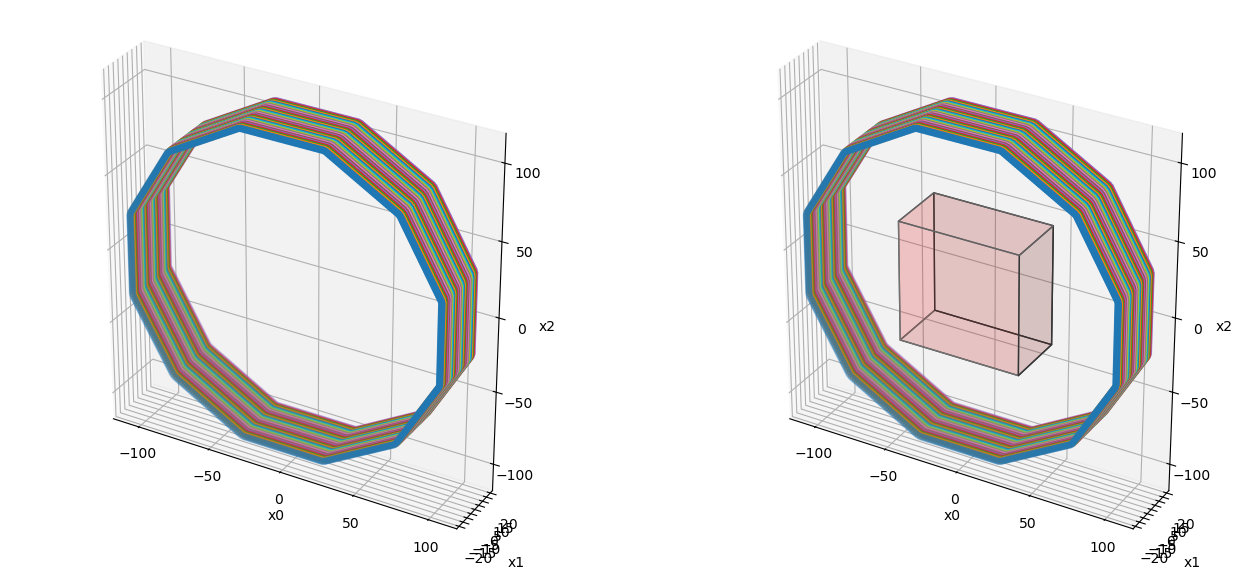

In [5]:
# Create the miniPET geometry
miniPET_geometry = get_miniPET_geometry(
    device=device, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, num_rings=IMG_DEPTH
)

# Show the miniPET geometry
miniPET_geometry.show()

## OSEM iterative algorithm: number of iterations and subsets
The image quality and the performance of the architectures are compared with the image quality and the performance achieved by the State-of-the-Art method, such as the OSEM algorithm, a fast variant of MLEM.
The number of subsets is set to 2 and the number of iterations to 9 as this is the one that produces the best results.

In [7]:
NOISE_LEVEL = 0.5

sinogram_slp, image_slp = create_SLPhantom(
    device, IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, miniPET_geometry.proj, NOISE_LEVEL
)

In [8]:
from copy import copy

import torch


from parallelproj import RegularPolygonPETProjector, LinearOperatorSequence


class OSEM:
    """Ordered Subset Expectation Maximization (OSEM) algorithm."""

    def __init__(
        self,
        projector: RegularPolygonPETProjector,
        device: torch.device,
        n_iterations: int = 10,
        n_subsets: int = 4,
    ) -> None:
        """
        Initialises the OSEM algorithm.

        Args:
            projector (RegularPolygonPETProjector): The projector.
            device (torch.device): The device to use.
            n_iterations (int, optional): The number of iterations. Defaults to 10.
            n_subsets (int, optional): The number of subsets. Defaults to 4.
        """
        self.projector = projector
        self.device = device
        self.n_iterations = n_iterations
        self.n_subsets = n_subsets

    def __call__(self, sinogram: torch.Tensor, target: torch.Tensor) -> tuple:
        """Run the OSEM algorithm.

        Args:
            sinogram (torch.Tensor): The sinogram.
            target (torch.Tensor): The target image.

        Returns:
            torch.Tensor: The reconstructed image.
        """
        # Get the image and sinogram shapes
        img_shape = self.projector.in_shape
        sino_shape = self.projector.out_shape

        # Get the distributed views and slices
        subset_views, subset_slices = (
            self.projector.lor_descriptor.get_distributed_views_and_slices(
                self.n_subsets, len(sino_shape)
            )
        )

        # Clear the cached LOR endpoints since we will create many copies of the projector
        self.projector.clear_cached_lor_endpoints()
        subset_proj_seq = []

        # Create the projector for each subset
        for i in range(self.n_subsets):
            subset_proj = copy(self.projector)
            subset_proj.views = subset_views[i]

            subset_proj_seq.append(subset_proj)

        # Create a sequence of linear operators, one for each subset
        subset_proj_seq = LinearOperatorSequence(subset_proj_seq)

        # Create the initial prediction as a tensor of ones
        prediction = torch.ones(img_shape).to(self.device)

        # Compute a list of backward projection of ones, one for each subset
        subset_adjoint_ones = [
            subset_proj.adjoint(torch.ones(subset_proj.out_shape).to(self.device))
            for subset_proj in subset_proj_seq
        ]

        mse_list = []
        psnr_list = []
        ssim_list = []
        predictions_list = []

        for _ in range(self.n_iterations):
            for k, sl in enumerate(subset_slices):
                # Compute the forward projection of the subset prediction
                foward_proj = subset_proj_seq[k](prediction)
                # Compute the ratio between the subset sinogram and the previous forward projection
                ratio = sinogram[sl] / (foward_proj + 1e-9)
                # Compute the backward projection of the ratio
                backward_proj = subset_proj_seq[k].adjoint(ratio)
                # Normalise and update the prediction
                prediction *= backward_proj / subset_adjoint_ones[k]

            # Append the prediction at iteration i
            predictions_list.append(prediction.cpu().numpy())

            # Compute and append the metrics at iteration i
            metrics = compute_metrics(target.cpu().numpy(), prediction.cpu().numpy())

            mse_list.append(metrics["mse"])

            psnr_list.append(metrics["psnr"])

            ssim_list.append(metrics["ssim"])

        metrics_list = {"mse": mse_list, "psnr": psnr_list, "ssim": ssim_list}

        return predictions_list, metrics_list

In [21]:
# MLEM reconstruction parameters
MLEM_ITERATIONS: int = 200
SUBSETS_LIST: list = [2, 4, 6, 8, 10]

In [16]:
metrics_subsets = []
for n in SUBSETS_LIST:
    # Initialise and run the MLEM algorithm
    osem = OSEM(
        projector=miniPET_geometry.proj,
        device=device,
        n_iterations=MLEM_ITERATIONS,
        n_subsets=n,
    )
    _, metrics_list = osem(sinogram=sinogram_slp, target=image_slp)
    metrics_subsets.append(metrics_list)

---- MSE ----
2:	1.29e-02
4:	1.29e-02
6:	1.30e-02
8:	1.30e-02
10:	1.31e-02
---- PSNR ----
2:	18.93
4:	18.92
6:	18.92
8:	18.91
10:	18.87
---- SSIM ----
2:	0.68
4:	0.68
6:	0.67
8:	0.68
10:	0.66


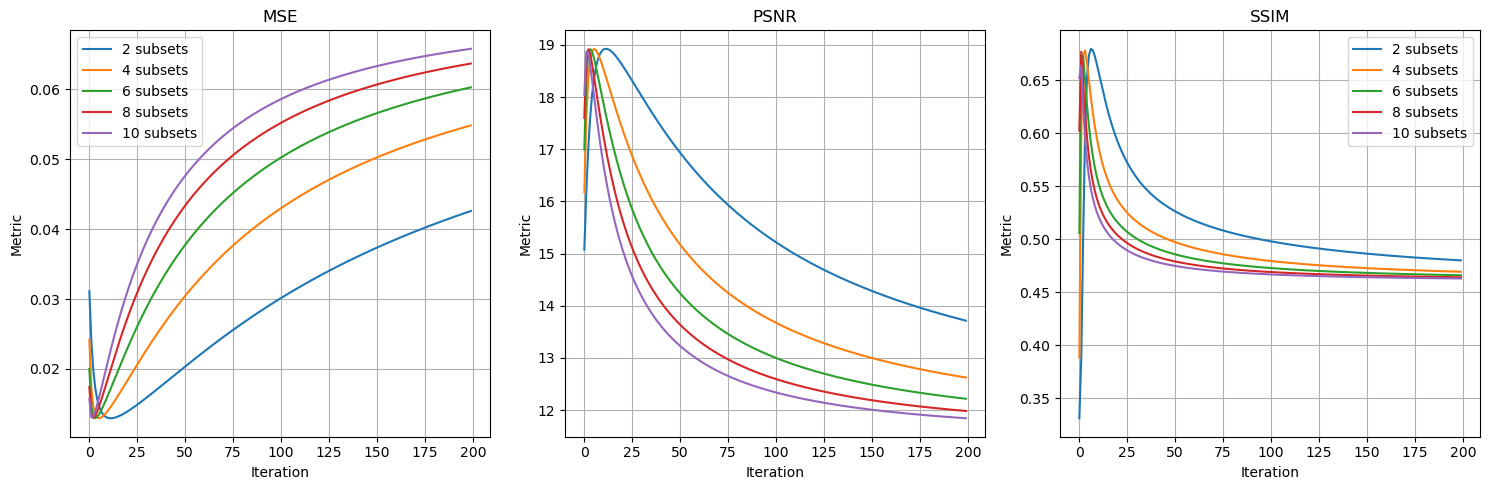

In [34]:
fig = plt.figure(figsize=(15, 5))

print("---- MSE ----")
ax1 = fig.add_subplot(1, 3, 1)
for i, n in enumerate(SUBSETS_LIST):
    metrics = metrics_subsets[i]["mse"]
    ax1.plot(metrics, label=f"{n} subsets")
    print(f"{n}:\t{np.min(metrics):.2e}")

ax1.grid(True)
ax1.set_title("MSE")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Metric")
ax1.legend()

print("---- PSNR ----")
ax2 = fig.add_subplot(1, 3, 2)
for i, n in enumerate(SUBSETS_LIST):
    metrics = metrics_subsets[i]["psnr"]
    ax2.plot(metrics, label=f"{n} subsets")
    print(f"{n}:\t{np.max(metrics):.2f}")
ax2.grid(True)
ax2.set_title("PSNR")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Metric")
ax1.legend()

print("---- SSIM ----")
ax3 = fig.add_subplot(1, 3, 3)
for i, n in enumerate(SUBSETS_LIST):
    metrics = metrics_subsets[i]["ssim"]
    ax3.plot(metrics, label=f"{n} subsets")
    print(f"{n}:\t{np.max(metrics):.2f}")
ax3.grid(True)
ax3.set_title("SSIM")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Metric")
ax3.legend()

plt.tight_layout()
plt.show()

In [39]:
metrics = metrics_subsets[0]  # 2 subsets

min_mse_iter = metrics["mse"].index(min(metrics["mse"]))
max_psnr_iter = metrics["psnr"].index(max(metrics["psnr"]))
max_ssim_iter = metrics["ssim"].index(max(metrics["ssim"]))
best_num_iter = int(np.round(np.mean([min_mse_iter, max_psnr_iter, max_ssim_iter])))
print(
    f"- Minumum MSE at iteration {min_mse_iter}\n- Maximum PSNR at iteration {max_psnr_iter}\n- Maximum SSIM at iteration {max_ssim_iter}\n\nBest number of iterations: {best_num_iter}"
)

- Minumum MSE at iteration 11
- Maximum PSNR at iteration 11
- Maximum SSIM at iteration 6

Best number of iterations: 9
